In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import random
import pickle
import osmnx as ox

In [2]:
"""
Set seed
"""
random.seed(0)

In [3]:
"""
Build a graph
"""

# Read the network data 
G = pickle.load(open("Manhattan_network.p", "rb"))


# Generate the set of nodes of a subgraph by BFS
def graph_generator(G, num_nodes):
    V = list(G.nodes)
    E = list(G.edges)
    s = random.sample(V, 1)[0]

    visited = [s]
    frontier = [s]
    while len(visited) < num_nodes and len(frontier) > 0:
        i = frontier.pop(0)
        for j in G.neighbors(i):
            if j not in visited:
                visited.append(j)
                frontier.append(j)
    
    return visited

num_nodes = 100
tmp_V = graph_generator(G, num_nodes)
G = G.subgraph(tmp_V)


# Extract the strongly connected components
tmp_V = max(nx.strongly_connected_components(G), key = len)
G = G.subgraph(list(tmp_V))
V = list(G.nodes)
E = list(G.edges)


# Visualization
# print(nx.is_strongly_connected(G))
# ox.plot_graph(G)

In [5]:
"""
Set parameters
"""

## Depots
num_depot = 1
K = random.sample(V, num_depot)

## Turcks
num_auto = 2
num_non_auto = 2
truck = np.arange((num_non_auto + num_auto) * num_depot)

# Comment the following if we fix the number of E-trucks and human-driven trucks
# num_auto = [np.random.randint(2, 6) for _ in range(num_depot)]
# num_non_auto = [np.random.randint(2, 6) for _ in range(num_depot)]
# # ! Pay attention to the indices
# truck = np.arange(sum(num_auto) + sum(num_non_auto))

truck_range = 50 * (np.random.random(len(truck)))
truck_capacity = np.repeat(30, len(truck))

## Clients
num_client = 5
D = random.sample(list(set(V) - set(K)), num_client)
demand = np.random.lognormal(0.1, 1, size=len(D))
demand_ext = np.hstack((np.zeros(num_depot), demand))


In [6]:
"""
Compute the cost array
"""

# Cost for human driving
H = K + D
cost_human_driven = np.zeros((len(H), len(H)))
for i in range(len(H)):
    for j in range(len(H)):
        cost_human_driven[i][j] = nx.dijkstra_path_length(G, H[i], H[j], weight = 'length')



In [7]:
# Cost for auto trucks (including cost for remote control)
for e in G.edges:
    if G.edges[e]['highway'] == 'primary':
        G.edges[e]['auto_cost'] = 0.5 * G.edges[e]['length']
    else:
        G.edges[e]['auto_cost'] = 1.2 * G.edges[e]['length']


cost_auto = np.zeros((len(H), len(H)))
for i in range(len(H)):
    for j in range(len(H)):
        cost_auto[i][j] = nx.dijkstra_path_length(G, H[i], H[j], weight = 'auto_cost')

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


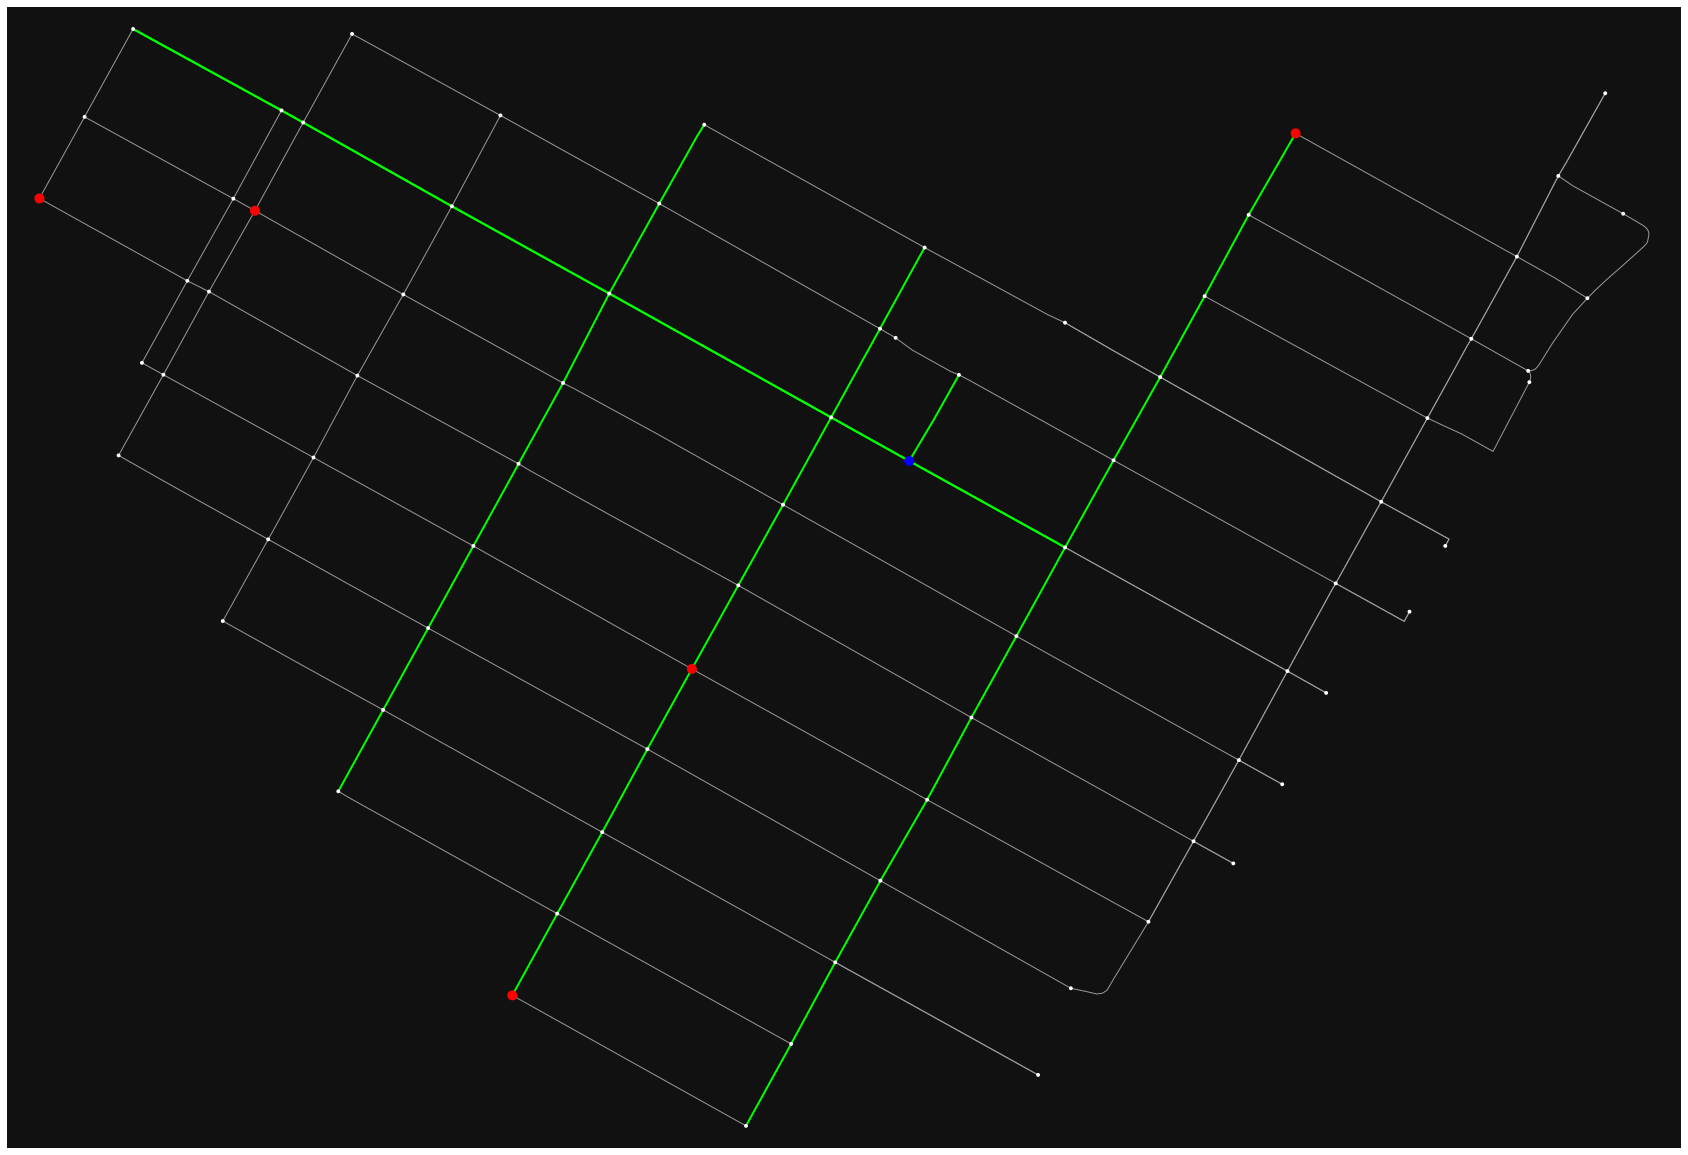

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [8]:
"""
Visualization
"""

index_K = [i for i in range(len(V)) if V[i] in K]
index_D = [i for i in range(len(V)) if V[i] in D]
index_auto_E = [i for i in range(len(E)) if G.edges[E[i]]['highway'] == 'primary']
node_color = ['w' for _ in range(len(V))]
node_size = [15 for _ in range(len(V))]
edge_color = ['#999999' for _ in range(len(E))]
edge_linewidth = [1 for _ in range(len(E))]

for idx in index_K:
    node_color[idx] = 'b'
    node_size[idx] = 100
for idx in index_D:
    node_color[idx] = 'r'
    node_size[idx] = 100
for idx in index_auto_E:
    edge_color[idx] = '#00FF00'
    edge_linewidth[idx] = 2

ox.plot_graph(G, node_color = node_color, node_size = node_size, edge_color = edge_color, 
                edge_linewidth = edge_linewidth, figsize = (30, 30), save = True)

In [9]:
"""
Solve the VRP by Gurobi (Flatten everything)
! # This one is not correct
"""

model = gp.Model('vrp')

# The structure of x variables are as follow: 
#   (1) | === truck-1 === | === truck-2 === | === truck-3 === | ...
#   (2) Within one block of truck, the i-th sub-block (containing |K| + |D| elems) corresponds
#       to the variable with the i-th depot/client as the source
#   (3) Depots preceed clients in terms of indices
size_x = len(H)**2 * len(truck)
x = model.addMVar(size_x,  vtype = GRB.BINARY, name = 'x')

# The structure of y and h variables are as follows:
#   (1) | === truck-1 === | === truck-2 === | === truck-3 === | ...
#   (2) The i-th (num_non_auto + num_auto) trucks belong to depot i
#   (3) non_auto trucks proceed auto trucks
#   (4) Each block contains |K| + |D| elements
#   (5) Depots preceed clients in terms of indices
size_yh = len(H) * len(truck)
y = model.addMVar(size_yh, vtype = GRB.BINARY, name = 'y')
h = model.addMVar(size_yh, lb = np.tile(demand_ext, len(truck)), \
    # ! The following line is valid only because all trucks have the same capacity
    ub = np.tile(truck_capacity, len(H)), vtype = GRB.CONTINUOUS, name = 'h')


# Constraints
# 1
model.addConstrs(sum(y[(i + len(K)): size_yh: len(H)]) == 1 for i in range(len(D)))

# 2
for k in range(len(K)):
    start_1 = k + k * (num_non_auto + num_auto) * len(H)
    end_1 = start_1 + num_non_auto * len(H)
    start_2 = end_1
    end_2 = end_1 + num_auto * len(H)
    step = len(H)
    model.addConstr(sum(y[start_1: end_1: step]) <= num_non_auto)
    model.addConstr(sum(y[start_2: end_2: step]) <= num_auto)

# 3
for i in range(len(H)):
    for m in range(len(truck)):

        start_1 = i * len(H) + m * len(H)**2
        end_1 = start_1 + len(H)
        model.addConstr(sum(x[start_1: end_1]) == y[i + m * len(H)])

        start_2 = i + m * len(H)**2
        end_2 = (m + 1) * len(H)**2
        step_2 = len(H)
        model.addConstr(sum(x[start_2: end_2: step_2]) == y[i + m * len(H)])

        model.addConstr(x[m * len(H)**2 + i + i * len(H)] == 0)


# 4 (Sub-tour elimination)
for i in range(len(H)):
    for j in range(len(H)):
        for m in  range(len(truck)):

            model.addConstr(h[i + m * len(H)] - h[j + m * len(H)] + truck_capacity[m] * (x[j + i * len(H) + m * len(H)**2] - 1) + demand_ext[i] <= 0)

            
# 5 (Range limit)


# The objective
cost_1 = np.tile(cost_human_driven.flatten(), num_non_auto)
cost_2 = np.tile(cost_auto.flatten(), num_auto)
cost = np.tile(np.hstack((cost_1, cost_2)), len(K))
model.setObjective(cost @ x, sense = GRB.MINIMIZE)

# Wirte the model
model.write('vrp.lp')

# Solve the VRP
model.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-23
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads
Optimize a model with 223 rows, 192 columns and 768 nonzeros
Model fingerprint: 0x5d7fff07
Variable types: 24 continuous, 168 integer (168 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+02, 2e+03]
  Bounds range     [4e-01, 3e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 55 rows and 29 columns
Presolve time: 0.00s
Presolved: 168 rows, 163 columns, 1016 nonzeros
Variable types: 24 continuous, 139 integer (139 binary)

Root relaxation: objective 2.820726e+03, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2820.72627    0   10          - 2820.72627      

In [ ]:
"""
A Time tracker
"""